**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

**Note**: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Get the data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    if not os.path.isfile(tgz_path):
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [13]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,NaN,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,NaN,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,NaN,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


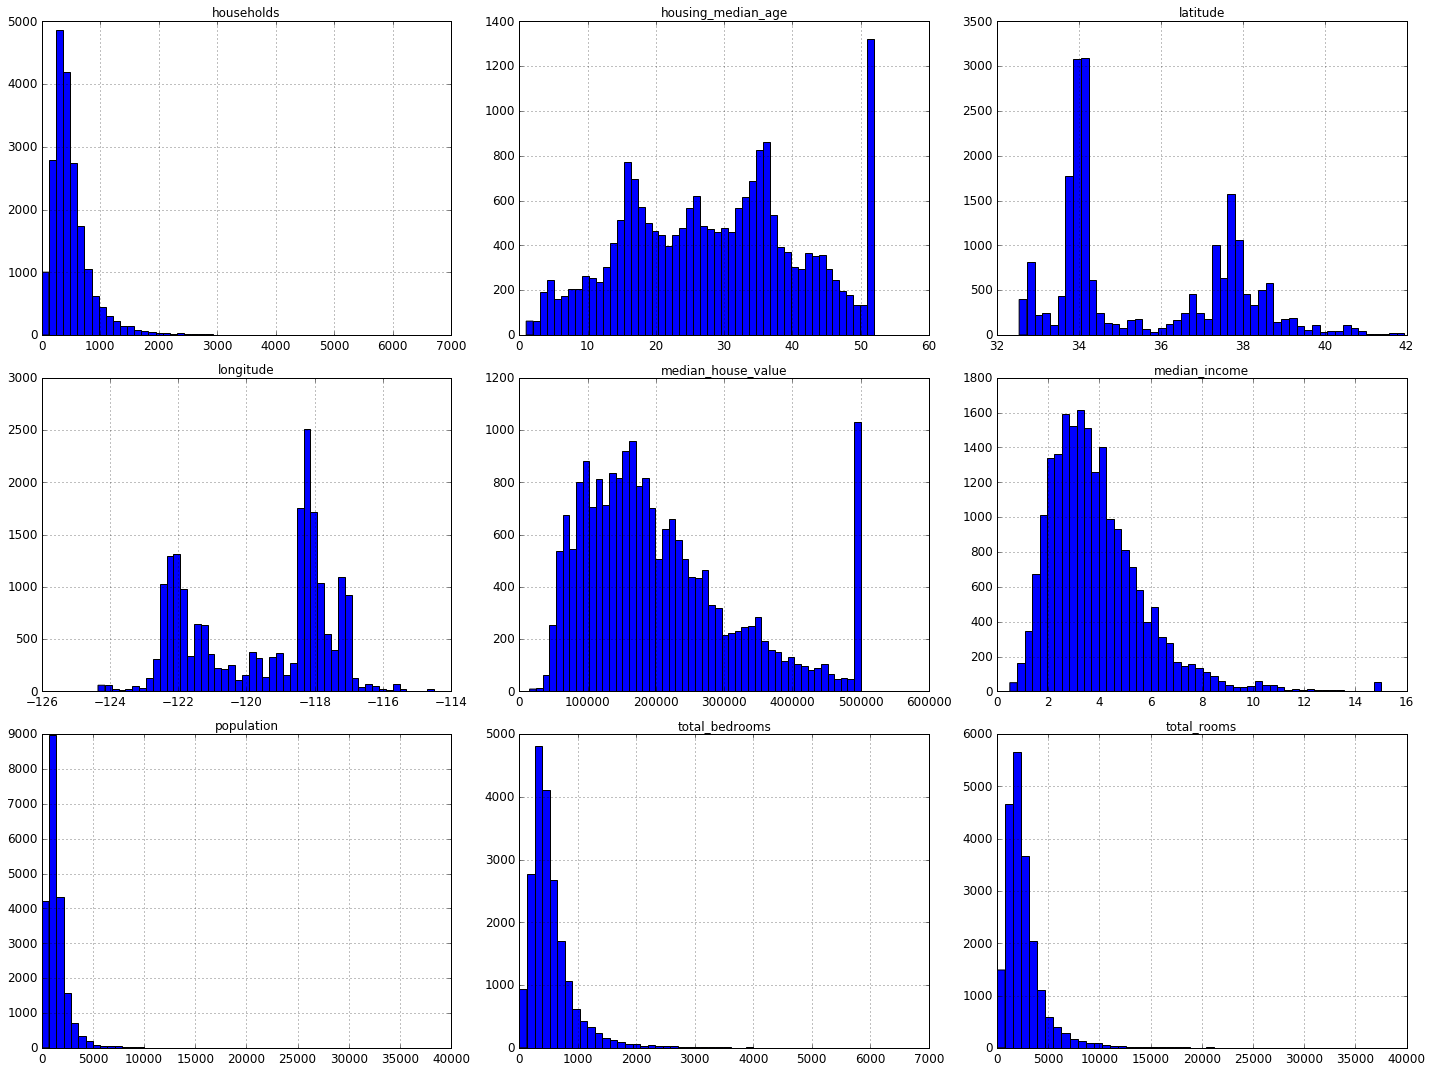

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [15]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [16]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [19]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [36]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [37]:
# This version supports both Python 2 and Python 3, instead of just Python 3.
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [40]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [43]:
# add id column
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [44]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [45]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [46]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


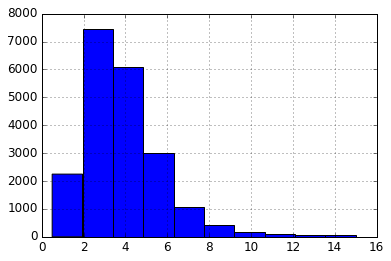

In [47]:
housing["median_income"].hist()

In [66]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [67]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

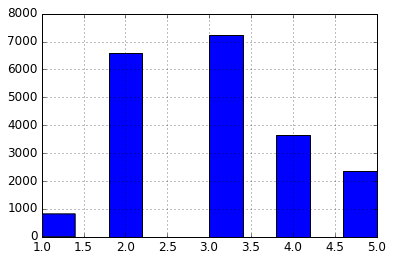

In [68]:
housing["income_cat"].hist()

In [70]:
# 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
housing["income_cat"].value_counts() / len(housing)

In [75]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [76]:
compare_props
# As you can see, strat_test_set has income category proportions almost identical to those in the full dataset

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [ ]:
#Now you should remove the income_cat attribute so the data is back to its original state:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [79]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


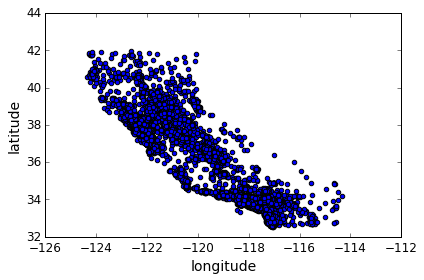

In [80]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

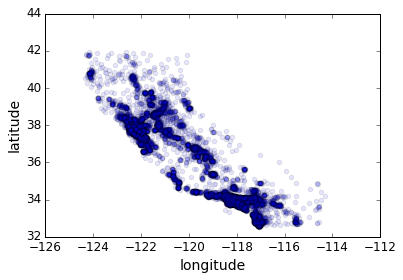

In [84]:
# with transparent level
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) 
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


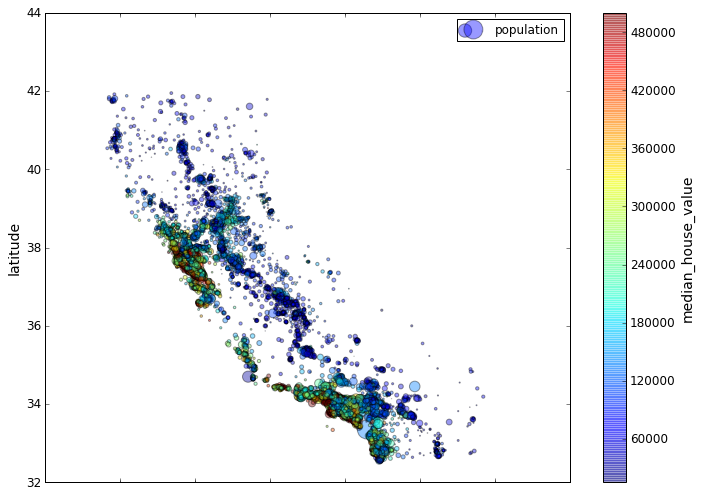

In [86]:
# The radius of each circle represents the district’s population (option s), 
# and the color represents the price (option c)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

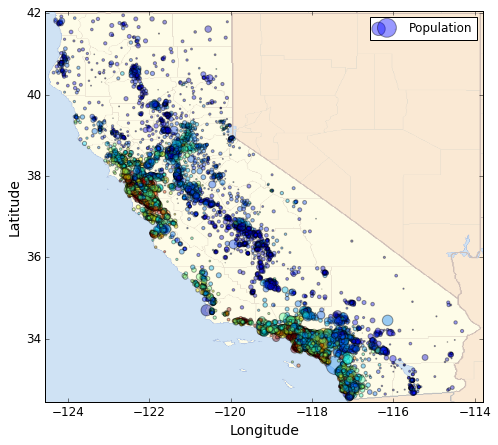

In [105]:
# plot with map
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [113]:
housing['total_rooms']/housing['households']

17606     4.625369
18632     6.008850
14650     4.225108
3230      5.232295
3555      4.505810
19480     5.140351
8879      8.061372
13685     5.442667
4937      4.257991
4861      2.373272
16365     4.729238
19684     4.314229
19234     6.648221
13956    16.688742
2390      6.946387
11176     4.785835
15614     2.671202
2953      4.555147
13209     4.672589
6569      5.594796
5825      4.242958
18086     7.237676
16718     4.996610
13600     6.237226
13989     5.542234
15168     4.234694
6747      5.382739
7398      3.448454
5562      3.827160
16121     5.121891
           ...    
12380     6.427504
5618      2.565217
10060     6.013462
18067     7.336471
4471      3.665826
19786     7.848837
9969      5.831858
14621     4.073093
579       6.696296
11682     4.240481
245       4.181818
12130     4.651838
16441     5.177570
11016     6.815725
19934     4.097744
1364      3.933333
1236     11.490862
5364      5.086142
11703     6.298742
10356     6.984547
15270     6.775210
3754      4.

In [94]:
corr_matrix = housing.corr()

In [99]:
corr_matrix["median_house_value"].sort_values(ascending=False)
# warn: The correlation coefficient only measures linear correlations

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


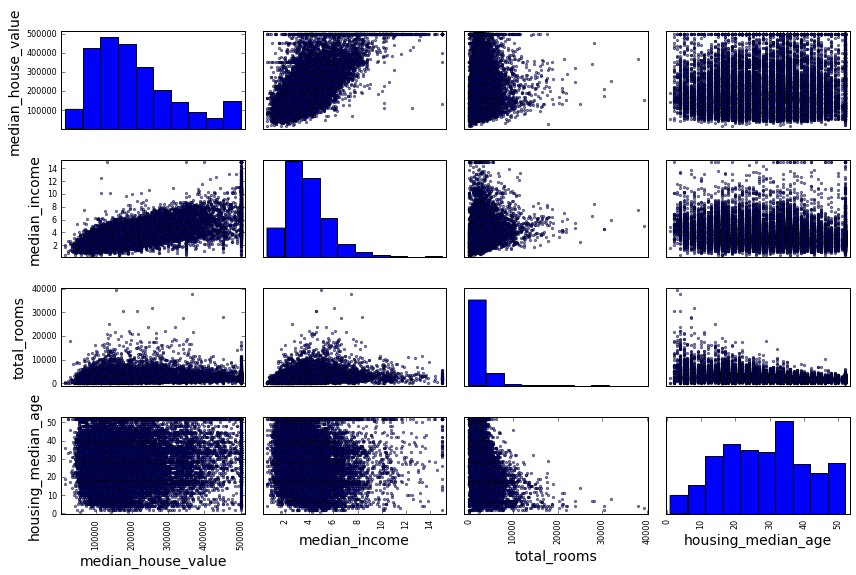

In [106]:
from pandas.tools.plotting import scatter_matrix
# see topn attr correlation matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


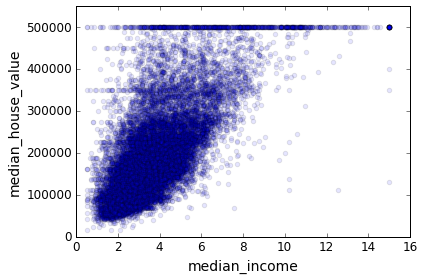

In [108]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])  # [x_min, x_max, y_min, y_max] axis range
save_fig("income_vs_house_value_scatterplot")

#this plot reveals other less obvious straight lines: a horizontal line around $450,000, 
# another around $350,000, perhaps one around $280,000, and a few more below that.

In [38]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [39]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

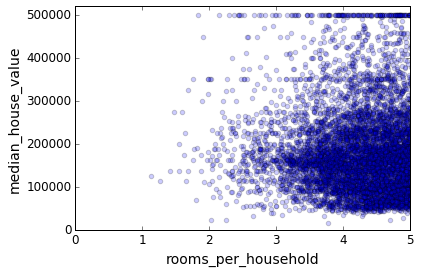

In [40]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [41]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [114]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [133]:
# use isnull(), get rows by axis=1
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [124]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1, drop whold rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [129]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2, drop attribute

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [135]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [139]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [140]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [141]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy=u'median',
    verbose=0)

In [142]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Check that this is the same as manually computing the median of each attribute: they are same

In [143]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Transform the training set:

In [144]:
X = imputer.transform(housing_num)

In [150]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [149]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [161]:
print(len(sample_incomplete_rows))
# location of missing data
housing_tr.loc[sample_incomplete_rows.index.values]

5


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [55]:
imputer.strategy

'median'

In [196]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
# now all values are not null
assert housing_tr.notnull().values.all()
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [197]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [198]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [199]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [200]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [203]:
# We can apply both transformations (from text categories to integer categories, 
# then from integer categories to one-hot vectors) in one shot using the LabelBinarizer class:

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform(). You can get the last one for free by simply adding TransformerMixin as a base class. Also, if you add BaseEstimator as a base class (and avoid *args and `**`kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning.  

In [211]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # concatenation along the second axis.
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [222]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [223]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [228]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [229]:
from sklearn.base import BaseEstimator, TransformerMixin

# To use pipeline, create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [234]:
housing_num.columns

Index([u'longitude', u'latitude', u'housing_median_age', u'total_rooms',
       u'total_bedrooms', u'population', u'households', u'median_income'],
      dtype='object')

In [235]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

In [236]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [237]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [238]:
housing_prepared.shape

(16512, 16)

# Select and train a model 

In [239]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [240]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849878]


Compare against the actual values:

In [241]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


## Select a Performance Measure
* RMSE: L2 norm, root mean square error
* MAE: L1 norm, mean absolute error

The higher the norm index, the more it focuses on large values and neglects small ones. This is why the RMSE is more sensitive to outliers than the MAE.


In [243]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

In [244]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018958

In [245]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [246]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation.

# Fine-tune your model

In [255]:
# use cross validation to get RMSE
from sklearn.model_selection import cross_val_score
def rmse_cv(model, X, y):
    scores = cross_val_score(model, X, y,
                        scoring="neg_mean_squared_error", cv=10)
    return np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [253]:
tree_rmse_scores = rmse_cv(tree_reg, housing_prepared, housing_labels)
display_scores(tree_rmse_scores)

Scores: [ 70232.0136482   66828.46839892  72444.08721003  70761.50186201
  71125.52697653  75581.29319857  70169.59286164  70055.37863456
  75370.49116773  71222.39081244]
Mean: 71379.0744771
Standard deviation: 2458.31882043


In [256]:
lin_rmse_scores = rmse_cv(lin_reg, housing_prepared, housing_labels)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70361.18285107  74742.02420674
  68022.09224176  71191.82593104  64969.63056405  68276.69992785
  71543.69797334  67665.10082067]
Mean: 69051.5111027
Standard deviation: 2732.29380552


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [258]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [259]:
# training rmse
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [260]:
display_scores(rmse_cv(forest_reg, housing_prepared, housing_labels))
# better than previous models currently

Scores: [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Mean: 52564.1902524
Standard deviation: 2301.87380392


In [261]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69051.636080
std       2880.194509
min      64969.630564
25%      67136.363758
50%      68149.396085
75%      70985.098467
max      74742.029570
dtype: float64

In [262]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [263]:
# cpu consuming
# display_scores(rmse_cv(svm_reg, housing_prepared, housing_labels))

Scores: [ 105342.09141998  112489.24624123  110092.35042753  113403.22892482
  110638.90119657  115675.8320024   110703.56887243  114476.89008206
  113756.17971227  111520.1120808 ]
Mean: 111809.840096
Standard deviation: 2762.39366432


### Grid Search

In [268]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{u'n_estimators': [3, 10, 30, 100], u'max_features': [2, 4, 6, 8]}, {u'n_estimators': [3, 10], u'max_features': [2, 3, 4], u'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=u'neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [270]:
grid_search.best_params_

{u'max_features': 8, u'n_estimators': 100}

In [271]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [273]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63825.0479302 {u'max_features': 2, u'n_estimators': 3}
55643.8429091 {u'max_features': 2, u'n_estimators': 10}
53380.6566859 {u'max_features': 2, u'n_estimators': 30}
52026.6053875 {u'max_features': 2, u'n_estimators': 100}
60959.1388585 {u'max_features': 4, u'n_estimators': 3}
52740.5841667 {u'max_features': 4, u'n_estimators': 10}
50374.1421461 {u'max_features': 4, u'n_estimators': 30}
49630.6908124 {u'max_features': 4, u'n_estimators': 100}
58661.2866462 {u'max_features': 6, u'n_estimators': 3}
52009.9739798 {u'max_features': 6, u'n_estimators': 10}
50154.1177737 {u'max_features': 6, u'n_estimators': 30}
49392.4721488 {u'max_features': 6, u'n_estimators': 100}
57865.3616801 {u'max_features': 8, u'n_estimators': 3}
51730.0755087 {u'max_features': 8, u'n_estimators': 10}
49694.8514333 {u'max_features': 8, u'n_estimators': 30}
49222.9956516 {u'max_features': 8, u'n_estimators': 100}
62874.4073931 {u'max_features': 2, u'n_estimators': 3, u'bootstrap': False}
54561.9398157 {u'max_feature

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [275]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={u'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10bb12f10>, u'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10bb12e90>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=u'neg_mean_squared_error',
          verbose=0)

In [278]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.1524172 {u'max_features': 7, u'n_estimators': 180}
51396.8768969 {u'max_features': 5, u'n_estimators': 15}
50798.3025423 {u'max_features': 3, u'n_estimators': 72}
50840.744514 {u'max_features': 5, u'n_estimators': 21}
49276.1753033 {u'max_features': 7, u'n_estimators': 122}
50776.7360494 {u'max_features': 3, u'n_estimators': 75}
50682.7075546 {u'max_features': 3, u'n_estimators': 88}
49612.1525305 {u'max_features': 5, u'n_estimators': 100}
50472.6107336 {u'max_features': 3, u'n_estimators': 150}
64458.2538503 {u'max_features': 5, u'n_estimators': 2}


In [279]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  6.98748803e-02,   6.27419695e-02,   4.35002137e-02,
         1.47250392e-02,   1.49328025e-02,   1.51565826e-02,
         1.45505357e-02,   3.69000561e-01,   5.29064702e-02,
         1.11000791e-01,   6.01066916e-02,   6.83578605e-03,
         1.58976811e-01,   6.85692516e-05,   2.16068818e-03,
         3.46160923e-03])

In [280]:
# show topn features 
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36900056050558055, 'median_income'),
 (0.15897681093196894, 'INLAND'),
 (0.11100079053661582, u'pop_per_hhold'),
 (0.0698748803293089, 'longitude'),
 (0.062741969453309746, 'latitude'),
 (0.060106691641964763, u'bedrooms_per_room'),
 (0.052906470181692963, u'rooms_per_hhold'),
 (0.043500213691814726, 'housing_median_age'),
 (0.015156582572749855, 'population'),
 (0.014932802549642904, 'total_bedrooms'),
 (0.014725039240194658, 'total_rooms'),
 (0.014550535650051761, 'households'),
 (0.0068357860518605037, '<1H OCEAN'),
 (0.0034616092295667138, 'NEAR OCEAN'),
 (0.0021606881820953484, 'NEAR BAY'),
 (6.8569251581897717e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful--INLAND, so you could try dropping the others).

In [283]:
#Evaluate Your System on the Test Set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47190.791688778867

# Extra material

## Label Binarizer hack
`LabelBinarizer`'s `fit_transform()` method only accepts one parameter `y` (because it was meant for labels, not predictors), so it does not work in a pipeline where the final estimator is a supervised estimator because in this case its `fit()` method takes two parameters `X` and `y`.

This hack creates a supervision-friendly `LabelBinarizer`.

In [277]:
class SupervisionFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(SupervisionFriendlyLabelBinarizer, self).fit_transform(X)

# Replace the Labelbinarizer with a SupervisionFriendlyLabelBinarizer
cat_pipeline.steps[1] = ("label_binarizer", SupervisionFriendlyLabelBinarizer())

# Now you can create a full pipeline with a supervised predictor at the end.
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 210644.60459286,  317768.80697211,  210956.43331178,
         59218.98886849,  189747.55849878])

## Model persistence using joblib

In [284]:
my_model = full_pipeline_with_predictor

In [285]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

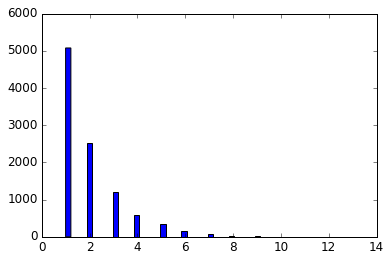

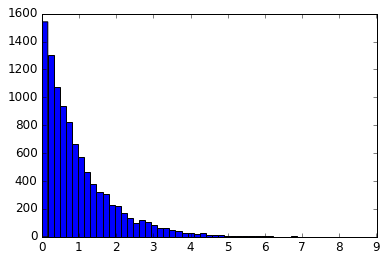

In [287]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [288]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] kernel=linear, C=10.0 ...........................................
[CV] kernel=linear, C=10.0 ...........................................
[CV] kernel=linear, C=10.0 ...........................................
[CV] kernel=linear, C=10.0 ...........................................
[CV] ............................ kernel=linear, C=10.0, total=  31.6s
[CV] kernel=linear, C=10.0 ...........................................
[CV] ............................ kernel=linear, C=10.0, total=  31.7s
[CV] kernel=linear, C=30.0 ...........................................
[CV] ............................ kernel=linear, C=10.0, total=  31.7s
[CV] kernel=linear, C=30.0 ...........................................
[CV] ............................ kernel=linear, C=10.0, total=  31.9s
[CV] kernel=linear, C=30.0 ...........................................
[CV] ............................ kernel=linear, C=30.0, total=  33.8s
[CV] kernel=lin

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  7.5min


[CV] ......................... kernel=linear, C=10000.0, total=  45.7s
[CV] kernel=linear, C=30000.0 ........................................
[CV] ......................... kernel=linear, C=10000.0, total=  39.9s
[CV] kernel=linear, C=30000.0 ........................................
[CV] ......................... kernel=linear, C=30000.0, total= 1.1min
[CV] kernel=linear, C=30000.0 ........................................
[CV] ......................... kernel=linear, C=30000.0, total=  57.8s
[CV] kernel=rbf, C=1.0, gamma=0.01 ...................................
[CV] ......................... kernel=linear, C=30000.0, total=  59.3s
[CV] kernel=rbf, C=1.0, gamma=0.01 ...................................
[CV] ......................... kernel=linear, C=30000.0, total=  54.9s
[CV] kernel=rbf, C=1.0, gamma=0.01 ...................................
[CV] ......................... kernel=linear, C=30000.0, total=  42.9s
[CV] kernel=rbf, C=1.0, gamma=0.01 ...................................
[CV] .

[CV] ..................... kernel=rbf, C=3.0, gamma=1.0, total=  19.4s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=1.0, total=  19.5s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=1.0, total=  19.6s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=1.0, total=  19.5s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=3.0, total=  20.0s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=3.0, total=  21.1s
[CV] kernel=rbf, C=10.0, gamma=0.01 ..................................
[CV] ..................... kernel=rbf, C=3.0, gamma=3.0, total=  21.2s
[CV] kernel=rbf, C=10.0, gamma=0.01 ..................................
[CV] .

[CV] .................... kernel=rbf, C=30.0, gamma=0.3, total=  18.2s
[CV] kernel=rbf, C=30.0, gamma=1.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=  17.8s
[CV] kernel=rbf, C=30.0, gamma=1.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=  18.4s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=  19.3s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=  18.7s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 28.5min


[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=  18.5s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=  20.1s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=  19.5s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=  19.8s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=  19.8s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=  21.4s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .................. kernel=rbf, C=100.0, gamma=0.01, total=  19.1s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .

[CV] ................... kernel=rbf, C=300.0, gamma=1.0, total=  17.9s
[CV] kernel=rbf, C=300.0, gamma=3.0 ..................................
[CV] ................... kernel=rbf, C=300.0, gamma=1.0, total=  17.7s
[CV] kernel=rbf, C=300.0, gamma=3.0 ..................................
[CV] ................... kernel=rbf, C=300.0, gamma=1.0, total=  17.8s
[CV] kernel=rbf, C=300.0, gamma=3.0 ..................................
[CV] ................... kernel=rbf, C=300.0, gamma=3.0, total=  19.9s
[CV] kernel=rbf, C=300.0, gamma=3.0 ..................................
[CV] ................... kernel=rbf, C=300.0, gamma=3.0, total=  19.4s
[CV] kernel=rbf, C=1000.0, gamma=0.01 ................................
[CV] ................... kernel=rbf, C=300.0, gamma=3.0, total=  20.1s
[CV] kernel=rbf, C=1000.0, gamma=0.01 ................................
[CV] ................... kernel=rbf, C=300.0, gamma=3.0, total=  20.2s
[CV] kernel=rbf, C=1000.0, gamma=0.01 ................................
[CV] .

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 39.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{u'kernel': [u'linear'], u'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {u'kernel': [u'rbf'], u'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], u'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=u'neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [291]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.903139641669

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [292]:
grid_search.best_params_

{u'C': 30000.0, u'kernel': u'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [312]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] kernel=linear, C=629.782329591, gamma=3.01012143092 .............
[CV] kernel=linear, C=629.782329591, gamma=3.01012143092 .............
[CV] kernel=linear, C=629.782329591, gamma=3.01012143092 .............
[CV] kernel=linear, C=629.782329591, gamma=3.01012143092 .............
[CV]  kernel=linear, C=629.782329591, gamma=3.01012143092, total=  16.3s
[CV]  kernel=linear, C=629.782329591, gamma=3.01012143092, total=  16.3s
[CV] kernel=linear, C=629.782329591, gamma=3.01012143092 .............
[CV] kernel=rbf, C=26290.2064643, gamma=0.908446969632 ...............
[CV]  kernel=linear, C=629.782329591, gamma=3.01012143092, total=  16.4s
[CV] kernel=rbf, C=26290.2064643, gamma=0.908446969632 ...............
[CV]  kernel=linear, C=629.782329591, gamma=3.01012143092, total=  16.4s
[CV] kernel=rbf, C=26290.2064643, gamma=0.908446969632 ...............
[CV]  kernel=linear, C=629.782329591, gamma=3.01012143092, total=  12.6s
[CV] 

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.8min


[CV] . kernel=rbf, C=108.304882388, gamma=0.36275372946, total=  20.7s
[CV] kernel=linear, C=21.3449536726, gamma=0.0233325235983 ...........
[CV] . kernel=rbf, C=108.304882388, gamma=0.36275372946, total=  20.7s
[CV] kernel=linear, C=21.3449536726, gamma=0.0233325235983 ...........
[CV] . kernel=rbf, C=108.304882388, gamma=0.36275372946, total=  20.9s
[CV] kernel=linear, C=21.3449536726, gamma=0.0233325235983 ...........
[CV]  kernel=linear, C=21.3449536726, gamma=0.0233325235983, total=  13.8s
[CV] kernel=rbf, C=5603.27031743, gamma=0.150234528727 ...............
[CV]  kernel=linear, C=21.3449536726, gamma=0.0233325235983, total=  14.1s
[CV] kernel=rbf, C=5603.27031743, gamma=0.150234528727 ...............
[CV]  kernel=linear, C=21.3449536726, gamma=0.0233325235983, total=  14.2s
[CV] kernel=rbf, C=5603.27031743, gamma=0.150234528727 ...............
[CV]  kernel=linear, C=21.3449536726, gamma=0.0233325235983, total=  14.7s
[CV] kernel=rbf, C=5603.27031743, gamma=0.150234528727 ......

[CV] kernel=rbf, C=8935.50563595, gamma=0.373546581658 ...............
[CV]  kernel=rbf, C=8935.50563595, gamma=0.373546581658, total=  19.0s
[CV] kernel=linear, C=135.767758248, gamma=0.838636245625 ............
[CV]  kernel=rbf, C=8935.50563595, gamma=0.373546581658, total=  19.1s
[CV] kernel=linear, C=135.767758248, gamma=0.838636245625 ............
[CV]  kernel=rbf, C=8935.50563595, gamma=0.373546581658, total=  19.5s
[CV] kernel=linear, C=135.767758248, gamma=0.838636245625 ............
[CV]  kernel=linear, C=135.767758248, gamma=0.838636245625, total=  14.7s
[CV] kernel=linear, C=135.767758248, gamma=0.838636245625 ............
[CV]  kernel=linear, C=135.767758248, gamma=0.838636245625, total=  14.6s
[CV] kernel=linear, C=135.767758248, gamma=0.838636245625 ............
[CV]  kernel=rbf, C=8935.50563595, gamma=0.373546581658, total=  19.5s
[CV] kernel=rbf, C=151136.202825, gamma=1.49224537714 ................
[CV]  kernel=linear, C=135.767758248, gamma=0.838636245625, total=  15.

[CV] kernel=linear, C=16483.8505298, gamma=1.47521452604 .............
[CV]  kernel=rbf, C=22.7692794106, gamma=0.221697602314, total=  19.3s
[CV] kernel=linear, C=16483.8505298, gamma=1.47521452604 .............
[CV]  kernel=rbf, C=22.7692794106, gamma=0.221697602314, total=  20.0s
[CV] kernel=linear, C=16483.8505298, gamma=1.47521452604 .............
[CV]  kernel=linear, C=16483.8505298, gamma=1.47521452604, total=  23.0s
[CV] kernel=linear, C=16483.8505298, gamma=1.47521452604 .............
[CV]  kernel=linear, C=16483.8505298, gamma=1.47521452604, total=  24.8s
[CV] kernel=rbf, C=101445.668813, gamma=1.05290408458 ................
[CV]  kernel=linear, C=16483.8505298, gamma=1.47521452604, total=  25.2s
[CV] kernel=rbf, C=101445.668813, gamma=1.05290408458 ................
[CV]  kernel=linear, C=16483.8505298, gamma=1.47521452604, total=  21.7s
[CV] kernel=rbf, C=101445.668813, gamma=1.05290408458 ................


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 25.0min


[CV]  kernel=linear, C=16483.8505298, gamma=1.47521452604, total=  25.5s
[CV] kernel=rbf, C=101445.668813, gamma=1.05290408458 ................
[CV] . kernel=rbf, C=101445.668813, gamma=1.05290408458, total= 1.5min
[CV] kernel=rbf, C=101445.668813, gamma=1.05290408458 ................
[CV] . kernel=rbf, C=101445.668813, gamma=1.05290408458, total= 1.4min
[CV] kernel=rbf, C=56681.8085903, gamma=0.976301191712 ...............
[CV] . kernel=rbf, C=101445.668813, gamma=1.05290408458, total= 1.8min
[CV] kernel=rbf, C=56681.8085903, gamma=0.976301191712 ...............
[CV] . kernel=rbf, C=101445.668813, gamma=1.05290408458, total= 1.9min
[CV] kernel=rbf, C=56681.8085903, gamma=0.976301191712 ...............
[CV]  kernel=rbf, C=56681.8085903, gamma=0.976301191712, total=  37.0s
[CV] kernel=rbf, C=56681.8085903, gamma=0.976301191712 ...............
[CV]  kernel=rbf, C=56681.8085903, gamma=0.976301191712, total=  38.1s
[CV] kernel=rbf, C=56681.8085903, gamma=0.976301191712 ...............
[CV]

[CV] kernel=linear, C=129.800060414, gamma=2.86213836765 .............
[CV]  kernel=linear, C=198.700478181, gamma=0.528281974883, total=  15.5s
[CV] kernel=linear, C=129.800060414, gamma=2.86213836765 .............
[CV]  kernel=linear, C=198.700478181, gamma=0.528281974883, total=  15.4s
[CV] kernel=linear, C=129.800060414, gamma=2.86213836765 .............
[CV]  kernel=linear, C=198.700478181, gamma=0.528281974883, total=  14.9s
[CV] kernel=linear, C=129.800060414, gamma=2.86213836765 .............
[CV]  kernel=linear, C=129.800060414, gamma=2.86213836765, total=  14.7s
[CV] kernel=linear, C=129.800060414, gamma=2.86213836765 .............
[CV]  kernel=linear, C=129.800060414, gamma=2.86213836765, total=  15.1s
[CV] kernel=rbf, C=288.426929959, gamma=0.1758083585 .................
[CV]  kernel=linear, C=129.800060414, gamma=2.86213836765, total=  16.0s
[CV] kernel=rbf, C=288.426929959, gamma=0.1758083585 .................
[CV]  kernel=linear, C=129.800060414, gamma=2.86213836765, tot

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 40.3min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=4,
          param_distributions={u'kernel': [u'linear', u'rbf'], u'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10a535f10>, u'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10d5e1f50>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=u'neg_mean_squared_error',
          verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [313]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.990537044083

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [314]:
rnd_search.best_params_

{u'C': 157055.10989448498, u'gamma': 0.26497040005002437, u'kernel': u'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

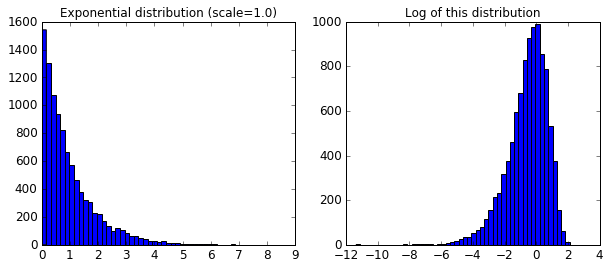

In [315]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. 
This distribution is useful when you don't have a clue of what the target scale is:

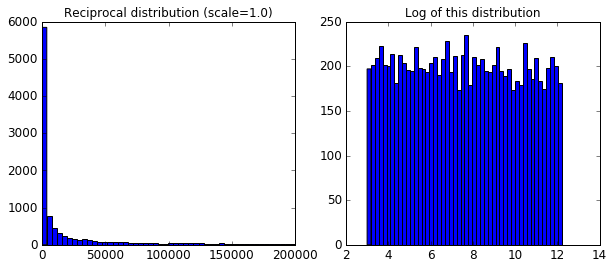

In [295]:
from scipy.stats import expon, reciprocal

reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [296]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [297]:
k = 5

Now let's look for the indices of the top k features:

In [316]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [317]:
np.array(attributes)[top_k_feature_indices]

array([u'longitude', u'latitude', u'median_income', u'pop_per_hhold',
       u'INLAND'], 
      dtype='<U18')

Let's double check that these are indeed the top k features:

In [318]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.36900056050558055, 'median_income'),
 (0.15897681093196894, 'INLAND'),
 (0.11100079053661582, u'pop_per_hhold'),
 (0.0698748803293089, 'longitude'),
 (0.062741969453309746, 'latitude')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [320]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [321]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [322]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Now let's double check that these are indeed the top k features:

In [323]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [324]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [325]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[(u'preparation', FeatureUnion(n_jobs=1,
       transformer_list=[(u'num_pipeline', Pipeline(steps=[(u'selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), (u'imputer', Impu....1,
  gamma=0.26497040005, kernel=u'rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

Let's try the full pipeline on a few instances:

In [326]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 203214.28978849  371846.88152572  173295.65441612   47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [327]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [3, 4, 5, 6, 7]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  12.9s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  12.9s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  13.0s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  1

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.8min


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean, total=  14.0s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean, total=  13.5s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  13.7s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  14.4s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  14.3s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  14.4

[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  6.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[(u'preparation', FeatureUnion(n_jobs=1,
       transformer_list=[(u'num_pipeline', Pipeline(steps=[(u'selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), (u'imputer', Impu....1,
  gamma=0.26497040005, kernel=u'rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{u'feature_selection__k': [3, 4, 5, 6, 7], u'preparation__num_pipeline__imputer__strategy': [u'mean', u'median', u'most_frequent']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=u'neg_mean_squared_error', verbose=2)

In [123]:
grid_search_prep.best_params_

{'feature_selection__k': 7,
 'preparation__num_pipeline__imputer__strategy': 'median'}

Great! It seems that we had the right imputer stragegy (mean), and apparently only the top 7 features are useful (out of 9), the last 2 seem to just add some noise.

In [124]:
housing.shape

(16512, 9)

Congratulations! You already know quite a lot about Machine Learning. :)